In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest.trainer import Trainer

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Himmelblau
#dims = 2
#def loglike(z):
#    z1 = z[:, 0]
#    z2 = z[:, 1]
#    return - (z1 ** 2 + z2 - 11.) ** 2 - (z1 + z2 ** 2 - 7.) ** 2
#def transform(x):
#    return 5. * x

In [6]:
# Rosenbrock
#dims = 3
#def loglike(z):
#    return np.array([-sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0) for x in z])
#def transform(x):
#    return 5. * x

In [7]:
# Gauss
#dims = 2
#corr = 0.99
#def loglike(x):
#    return multivariate_normal.logpdf(x, mean=np.zeros(dims), cov=np.eye(dims) + corr * (1 - np.eye(dims)))
#def transform(x):
#    return 3. * x

In [8]:
# Eggbox
dims = 2
def loglike(x):
    chi = (np.cos(x[:,0] / 2.))*(np.cos(x[:,1] / 2.))
    return (2. + chi)**5
def transform(x):
    return x * 5 * np.pi

In [9]:
n_samples = 1000
fraction = 0.02

In [10]:
np.random.seed(0)
x = 2 * (np.random.uniform(size=(int(n_samples / fraction), dims)) - 0.5)
likes = loglike(transform(x))
idx = np.argsort(-likes)
samples = x[idx[0:n_samples]]

In [11]:
t = Trainer(dims, 16, flow='spline')

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

In [12]:
t.train(samples, jitter=0.01)

[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0204] validation loss [0.0221]
[nnest.trainer] [INFO] Epoch [50] train loss [-0.0003] validation loss [-0.0019]
[nnest.trainer] [INFO] Epoch [100] train loss [-0.0096] validation loss [-0.0107]
[nnest.trainer] [INFO] Epoch [150] train loss [-0.0126] validation loss [-0.0140]
[nnest.trainer] [INFO] Epoch [200] train loss [-0.0144] validation loss [-0.0162]
[nnest.trainer] [INFO] Epoch [250] train loss [-0.0156] validation loss [-0.0170]
[nnest.trainer] [INFO] Epoch [300] train loss [-0.0162] validation loss [-0.0176]
[nnest.trainer] [INFO] Epoch [350] train loss [-0.0167] validation loss [-0.0182]
[nnest.trainer] [INFO] Epoch [400] train loss [-0.0167] validation loss [-0.0185]
[nnest.trainer] [INFO] Epoch [450] train loss [-0.0171] validation loss [-0.0186]
[nnest.trainer] [INFO] Epoch [500] train loss [-0.0168] validation loss [-0.0187

In [15]:
x_synth = t.netG.sample(samples.size).detach().cpu().numpy()
z = t.get_latent_samples(samples)

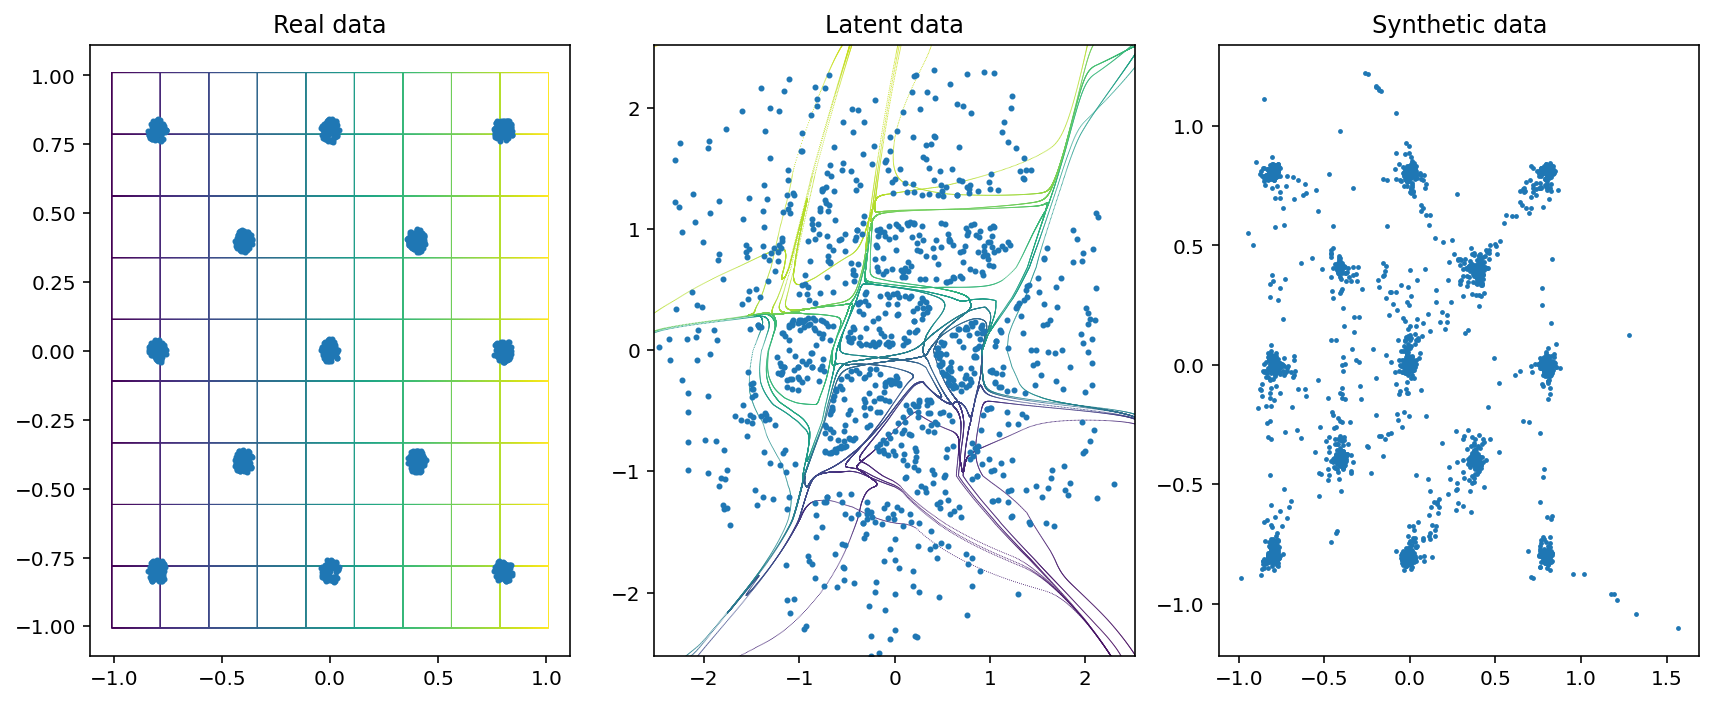

In [16]:
if dims == 2:
    grid = []
    for x in np.linspace(np.min(samples[:, 0])*1.2, np.max(samples[:, 0])*1.2, 10):
        for y in np.linspace(np.min(samples[:, 1])*1.2, np.max(samples[:, 1])*1.2, 5000):
            grid.append([x, y])
    for y in np.linspace(np.min(samples[:, 1])*1.2, np.max(samples[:, 1])*1.2, 10):
        for x in np.linspace(np.min(samples[:, 0])*1.2, np.max(samples[:, 0])*1.2, 5000):
            grid.append([x, y])
    grid = np.array(grid)
    z_grid = t.get_latent_samples(grid)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].scatter(grid[:, 0], grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[0].scatter(samples[:, 0], samples[:, 1], s=4)
    ax[0].set_title('Real data')
    ax[1].scatter(z_grid[:, 0], z_grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[1].scatter(z[:, 0], z[:, 1], s=4)
    ax[1].set_title('Latent data')
    ax[1].set_xlim([-np.max(np.abs(z)), np.max(np.abs(z))])
    ax[1].set_ylim([-np.max(np.abs(z)), np.max(np.abs(z))])
    ax[2].scatter(x_synth[:, 0], x_synth[:, 1], s=2)
    ax[2].set_title('Synthetic data')
    plt.tight_layout()
    plt.show()